![](https://images.pexels.com/photos/3701276/pexels-photo-3701276.jpeg?auto=compress&cs=tinysrgb&dpr=2&h=750&w=1260)

# Digital Compasses

Kevin J. Walchko, Phd

---

# Tilt Compensated Compass

Here we are using just the acceration and magnetometer data from the IMU to convert into Euler angles. This ignores the gyro readings. The code to calculate this is shown below:

```python
# normalize these these values
mx, my, mz = normalize3(*mag)
ax, ay, az = normalize3(*accel)

pitch = asin(-ax)

if abs(pitch) >= pi/2:
    roll = 0.0
else:
    roll = asin(ay/cos(pitch))

# mx, my, mz => magnetometer readins
x = mx*cos(pitch)+mz*sin(pitch)
y = mx*sin(roll)*sin(pitch)+my*cos(roll)-mz*sin(roll)*cos(pitch)
heading = atan2(y, x)

# wrap heading between 0 and 360 degrees
if heading > 2*pi:
    heading -= 2*pi
elif heading < 0:
    heading += 2*pi

# convert the results to either degrees or quaternion
if self.angle_units == Angle.degrees:
    roll    *= RAD2DEG
    pitch   *= RAD2DEG
    heading *= RAD2DEG
elif self.angle_units == Angle.quaternion:
    return Quaternion.from_euler(roll, pitch, heading)

return (roll, pitch, heading,)
```

# AHRS

An **attitude and heading reference system** (AHRS) consists of sensors on three axes that provide attitude information for aircraft, including roll, pitch and yaw. These are sometimes referred to as MARG (Magnetic, Angular Rate, and Gravity) sensors and consist of either solid-state or microelectromechanical systems (MEMS) gyroscopes, accelerometers and magnetometers. They are designed to replace traditional mechanical gyroscopic flight instruments.

```python
class AHRS(object):
	def __init__(self, q=None):
		if q is None:
			q = (1, 0, 0, 0)
		q = normalize_q(q)
		self.q = q

	def updateAGM(self, a, m, g, beta, dt):
		"""
		q - current quaternion
		a - acceleration [g's], this will be normalize
		m - magnetometer readings [uT], this will be normalized
		g - gyro readings [rad/sec]
		beta - function of sensor noise
		dt - time step [sec]
		"""
		q0, q1, q2, q3 = self.q
		gx, gy, gz = (deg2rad(x) for x in g)
		ax, ay, az = a
		mx, my, mz = m

		# Rate of change of quaternion from gyroscope
		qDot1 = 0.5 * (-q1 * gx - q2 * gy - q3 * gz)
		qDot2 = 0.5 * (q0 * gx + q2 * gz - q3 * gy)
		qDot3 = 0.5 * (q0 * gy - q1 * gz + q3 * gx)
		qDot4 = 0.5 * (q0 * gz + q1 * gy - q2 * gx)

		ax, ay, az = normalize(ax, ay, az)
		mx, my, mz = normalize(mx, my, mz)

		# Auxiliary variables to avoid repeated arithmetic
		_2q0mx = 2.0 * q0 * mx
		_2q0my = 2.0 * q0 * my
		_2q0mz = 2.0 * q0 * mz
		_2q1mx = 2.0 * q1 * mx
		_2q0 = 2.0 * q0
		_2q1 = 2.0 * q1
		_2q2 = 2.0 * q2
		_2q3 = 2.0 * q3
		_2q0q2 = 2.0 * q0 * q2
		_2q2q3 = 2.0 * q2 * q3
		q0q0 = q0 * q0
		q0q1 = q0 * q1
		q0q2 = q0 * q2
		q0q3 = q0 * q3
		q1q1 = q1 * q1
		q1q2 = q1 * q2
		q1q3 = q1 * q3
		q2q2 = q2 * q2
		q2q3 = q2 * q3
		q3q3 = q3 * q3

		# Reference direction of Earth's magnetic field
		hx = mx * q0q0 - _2q0my * q3 + _2q0mz * q2 + mx * q1q1 + _2q1 * my * q2 + _2q1 * mz * q3 - mx * q2q2 - mx * q3q3
		hy = _2q0mx * q3 + my * q0q0 - _2q0mz * q1 + _2q1mx * q2 - my * q1q1 + my * q2q2 + _2q2 * mz * q3 - my * q3q3
		_2bx = sqrt(hx * hx + hy * hy)
		_2bz = -_2q0mx * q2 + _2q0my * q1 + mz * q0q0 + _2q1mx * q3 - mz * q1q1 + _2q2 * my * q3 - mz * q2q2 + mz * q3q3
		_4bx = 2.0 * _2bx
		_4bz = 2.0 * _2bz

		# Gradient decent algorithm corrective step
		s0 = -_2q2 * (2.0 * q1q3 - _2q0q2 - ax) + _2q1 * (2.0 * q0q1 + _2q2q3 - ay) - _2bz * q2 * (_2bx * (0.5 - q2q2 - q3q3) + _2bz * (q1q3 - q0q2) - mx) + (-_2bx * q3 + _2bz * q1) * (_2bx * (q1q2 - q0q3) + _2bz * (q0q1 + q2q3) - my) + _2bx * q2 * (_2bx * (q0q2 + q1q3) + _2bz * (0.5 - q1q1 - q2q2) - mz)
		s1 = _2q3 * (2.0 * q1q3 - _2q0q2 - ax) + _2q0 * (2.0 * q0q1 + _2q2q3 - ay) - 4.0 * q1 * (1 - 2.0 * q1q1 - 2.0 * q2q2 - az) + _2bz * q3 * (_2bx * (0.5 - q2q2 - q3q3) + _2bz * (q1q3 - q0q2) - mx) + (_2bx * q2 + _2bz * q0) * (_2bx * (q1q2 - q0q3) + _2bz * (q0q1 + q2q3) - my) + (_2bx * q3 - _4bz * q1) * (_2bx * (q0q2 + q1q3) + _2bz * (0.5 - q1q1 - q2q2) - mz)
		s2 = -_2q0 * (2.0 * q1q3 - _2q0q2 - ax) + _2q3 * (2.0 * q0q1 + _2q2q3 - ay) - 4.0 * q2 * (1 - 2.0 * q1q1 - 2.0 * q2q2 - az) + (-_4bx * q2 - _2bz * q0) * (_2bx * (0.5 - q2q2 - q3q3) + _2bz * (q1q3 - q0q2) - mx) + (_2bx * q1 + _2bz * q3) * (_2bx * (q1q2 - q0q3) + _2bz * (q0q1 + q2q3) - my) + (_2bx * q0 - _4bz * q2) * (_2bx * (q0q2 + q1q3) + _2bz * (0.5 - q1q1 - q2q2) - mz)
		s3 = _2q1 * (2.0 * q1q3 - _2q0q2 - ax) + _2q2 * (2.0 * q0q1 + _2q2q3 - ay) + (-_4bx * q3 + _2bz * q1) * (_2bx * (0.5 - q2q2 - q3q3) + _2bz * (q1q3 - q0q2) - mx) + (-_2bx * q0 + _2bz * q2) * (_2bx * (q1q2 - q0q3) + _2bz * (q0q1 + q2q3) - my) + _2bx * q1 * (_2bx * (q0q2 + q1q3) + _2bz * (0.5 - q1q1 - q2q2) - mz)

		s0, s1, s2, s3 = normalize_q((s0, s1, s2, s3))

		# Apply feedback step
		qDot1 -= beta * s0
		qDot2 -= beta * s1
		qDot3 -= beta * s2
		qDot4 -= beta * s3

		q0 += qDot1 * dt
		q1 += qDot2 * dt
		q2 += qDot3 * dt
		q3 += qDot4 * dt

		q0, q1, q2, q3 = normalize_q((q0, q1, q2, q3))

		self.q = (q0, q1, q2, q3)

		return (q0, q1, q2, q3)

	def updateAG(self, q, a, g, beta, dt):
		q0, q1, q2, q3 = q
		gx, gy, gz = (deg2rad(x) for x in g)
		ax, ay, az = a

		# Rate of change of quaternion from gyroscope
		qDot1 = 0.5 * (-q1 * gx - q2 * gy - q3 * gz)
		qDot2 = 0.5 * (q0 * gx + q2 * gz - q3 * gy)
		qDot3 = 0.5 * (q0 * gy - q1 * gz + q3 * gx)
		qDot4 = 0.5 * (q0 * gz + q1 * gy - q2 * gx)

		# Compute feedback only if accelerometer measurement valid (avoids NaN in accelerometer normalisation)
		ax, ay, az = normalize(ax, ay, az)

		# Auxiliary variables to avoid repeated arithmetic
		_2q0 = 2.0 * q0
		_2q1 = 2.0 * q1
		_2q2 = 2.0 * q2
		_2q3 = 2.0 * q3
		_4q0 = 4.0 * q0
		_4q1 = 4.0 * q1
		_4q2 = 4.0 * q2
		_8q1 = 8.0 * q1
		_8q2 = 8.0 * q2
		q0q0 = q0 * q0
		q1q1 = q1 * q1
		q2q2 = q2 * q2
		q3q3 = q3 * q3

		# Gradient decent algorithm corrective step
		s0 = _4q0 * q2q2 + _2q2 * ax + _4q0 * q1q1 - _2q1 * ay
		s1 = _4q1 * q3q3 - _2q3 * ax + 4.0 * q0q0 * q1 - _2q0 * ay - _4q1 + _8q1 * q1q1 + _8q1 * q2q2 + _4q1 * az
		s2 = 4.0 * q0q0 * q2 + _2q0 * ax + _4q2 * q3q3 - _2q3 * ay - _4q2 + _8q2 * q1q1 + _8q2 * q2q2 + _4q2 * az
		s3 = 4.0 * q1q1 * q3 - _2q1 * ax + 4.0 * q2q2 * q3 - _2q2 * ay

		s0, s1, s2, s3 = normalize_q((s0, s1, s2, s3))

		# Apply feedback step
		qDot1 -= beta * s0
		qDot2 -= beta * s1
		qDot3 -= beta * s2
		qDot4 -= beta * s3

		# Integrate rate of change of quaternion to yield quaternion
		q0 += qDot1 * dt
		q1 += qDot2 * dt
		q2 += qDot3 * dt
		q3 += qDot4 * dt

		q0, q1, q2, q3 = normalize_q((q0, q1, q2, q3))

		self.q = (q0, q1, q2, q3)

		return (q0, q1, q2, q3)
```

# Get Data

In [1]:
import cv2         # opencv itself
import numpy as np # matrix manipulations

import the_collector # read data
print(f"the-collector: {the_collector.__version__}")

from the_collector import BagIt
from the_collector import Json, Pickle

from squaternion import Quaternion

import pandas as pd

from math import sqrt, atan2, asin, pi
from math import radians as deg2rad
from math import degrees as rad2deg

the-collector: 0.8.7


In [2]:
%matplotlib inline
from matplotlib import pyplot as plt 

In [3]:
!ls -lh

total 46448
-rw-r--r--  1 kevin  staff   204K Jun 28 22:17 attitude-heading-reference-system.ipynb
-rwx------  1 kevin  staff    11M Nov 23  2017 imu-1-2.json
-rwx------  1 kevin  staff    11M Apr 20 14:18 imu-1-2.json-gz
-rw-r--r--  1 kevin  staff   140K May  4  2019 imu-rpi.2019-05-04-20:47:18.445193.pickle.bag
-rw-r--r--  1 kevin  staff   554K Jan 27  2018 sensor_data.mp4


In [13]:
def bag_info(bag):
    print('Bag keys:')
    print('-'*50)
    for k in bag.keys():
        print(f'  {k:>10}: {len(bag[k]):<7}')

# bag = BagIt(Pickle)
# fname = "imu-rpi.2019-05-04-20:47:18.445193.pickle.bag"
# data = bag.read(fname)

bag = the_collector.BagIt(Json)
bag.packer.compress(True)
fname = "imu-1-2.json-gz.bag"
data = bag.read(fname)
# print(f">> Bagit keys: {data.keys()}")
bag_info(data)

>> Reading[json-gz]: imu-1-2.json-gz.bag
Bag keys:
--------------------------------------------------
        gyro: 585    
      camera: 585    
       accel: 585    
         mag: 585    
     b64keys: 1      


In [14]:
# data is an array of IMU messages
def get(bag, key):
    data = {"x":[], "y":[],"z":[],"ts":[]}
    for (x,y,z),ts in bag[key]:
        data["x"].append(x)
        data["y"].append(y)
        data["z"].append(z)
        data["ts"].append(ts)
    return data

adf = pd.DataFrame(get(data, "accel"))
gdf = pd.DataFrame(get(data, "gyro"))
mdf = pd.DataFrame(get(data, "mag"))
adf.describe()

,x,y,z,ts
count,585.000000,585.000000,585.000000,5.850000e+02
mean,0.057937,-0.048492,1.029675,1.511460e+09
std,0.030124,0.027924,0.032455,7.380804e+00
min,-0.044408,-0.143228,0.874008,1.511460e+09
25%,0.040748,-0.061488,1.021628,1.511460e+09
50%,0.055632,-0.050020,1.029436,1.511460e+09
75%,0.069296,-0.035624,1.037000,1.511460e+09
max,0.185928,0.116876,1.224880,1.511460e+09


## Calibrate Data

The bias was found in another application for this data

In [15]:
# cm = apply_calibration(mag, bias)
def remove_bias(ddf, off=0.0):
    df = pd.DataFrame()
    for key in ["x","y","z"]:
        df[key]=ddf[key] - ddf[key].mean() + off
    df["ts"] = ddf["ts"]
    return df

deg2rad = pi/180

madf = remove_bias(adf, off=1.0) # account for gravity
mgdf = remove_bias(gdf)
mmdf = remove_bias(mdf)

In [16]:
madf.describe()

,x,y,z,ts
count,585.000000,585.000000,585.000000,5.850000e+02
mean,1.000000,1.000000,1.000000,1.511460e+09
std,0.030124,0.027924,0.032455,7.380804e+00
min,0.897655,0.905264,0.844333,1.511460e+09
25%,0.982811,0.987004,0.991953,1.511460e+09
50%,0.997695,0.998472,0.999761,1.511460e+09
75%,1.011359,1.012868,1.007325,1.511460e+09
max,1.127991,1.165368,1.195205,1.511460e+09


In [17]:
mgdf.describe()

,x,y,z,ts
count,5.850000e+02,5.850000e+02,5.850000e+02,5.850000e+02
mean,4.858412e-17,-4.858412e-17,-3.109384e-15,1.511460e+09
std,1.887518e+00,2.045853e+00,6.274507e+01,7.380803e+00
min,-1.580984e+01,-7.995980e+00,-1.380545e+02,1.511460e+09
25%,-6.223424e-01,-8.553552e-01,-5.001545e+01,1.511460e+09
50%,-5.154915e-03,4.019765e-03,-6.170139e-01,1.511460e+09
75%,7.995326e-01,7.071448e-01,4.905486e+01,1.511460e+09
max,9.979220e+00,1.094933e+01,1.147580e+02,1.511460e+09


In [18]:
mmdf.describe()

,x,y,z,ts
count,5.850000e+02,5.850000e+02,5.850000e+02,5.850000e+02
mean,7.773459e-15,-7.773459e-16,3.352304e-15,1.511460e+09
std,1.440214e+01,1.656534e+01,1.332731e+00,7.380803e+00
min,-1.715231e+01,-2.323282e+01,-4.406667e+00,1.511460e+09
25%,-9.652308e+00,-1.553282e+01,-1.106667e+00,1.511460e+09
50%,-7.552308e+00,1.671795e-01,9.333333e-02,1.511460e+09
75%,7.847692e+00,1.786718e+01,1.093333e+00,1.511460e+09
max,3.124769e+01,2.416718e+01,3.193333e+00,1.511460e+09


In [19]:
from ins_nav import TiltCompensatedCompass

comp = TiltCompensatedCompass()


# get some iterators for each DataFrame
accel = madf.itertuples(index=False)
mag = mmdf.itertuples(index=False)

# going to create a new DataFrame from Euler angles
e = {"roll":[], "pitch":[],"yaw":[],"tt":[]}

last = madf["ts"][0] # starting time stamp
dt = 0.1             # time step
t0 = madf["ts"][0]   # starting time stamp

for aa, mm in zip(accel, mag):
    # data stored as ((x,y,z), timestamp), break appart
    a = aa[:3]
    m = mm[:3]
    ts = aa[3]
    r,p,y = comp.compensate(a,m)
    e["roll"].append(r)
    e["pitch"].append(p)
    e["yaw"].append(y)
    e["tt"].append(ts - t0)
    
euler = pd.DataFrame(e)

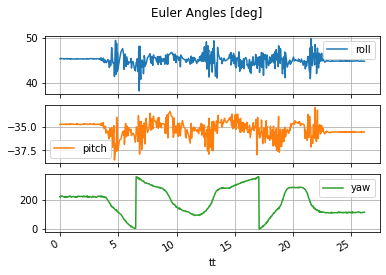

In [20]:
euler.plot(x="tt", subplots=True, grid=True, title="Euler Angles [deg]");

# Run AHRS

Now the AHRS uses all of the sensors in the IMU. The code is shown below:

In [21]:
import importlib
import ins_nav

In [22]:
ahrs = ins_nav.AHRS()
beta = 1.0

# get some iterators for each DataFrame
accel = madf.itertuples(index=False)
gyro = mgdf.itertuples(index=False)
mag = mmdf.itertuples(index=False)

# going to create a new DataFrame from Euler angles
e = {"roll":[], "pitch":[],"yaw":[],"tt":[]}

last = madf["ts"][0] # starting time stamp
tt = 0               # Test time

for aa, mm, gg in zip(accel, mag, gyro):
    # data stored as ((x,y,z), timestamp), break appart
    a = aa[:3]
    m = mm[:3]
    g = gg[:3]
    
    dt = aa[3] - last # calculate time step
    
    q = ahrs.updateAGM(a,m,g,beta,dt,degrees=True)  # get orientation
    r,p,y = q.to_euler(degrees=True)   # convert to euler
#     r,p,y = quat2euler(q)
    e["roll"].append(r)
    e["pitch"].append(p)
    e["yaw"].append(y)
    
    # keep track of test time
    tt += dt
    e["tt"].append(tt)
    
    last = aa[3]  # save previous time stamp

euler = pd.DataFrame(e)

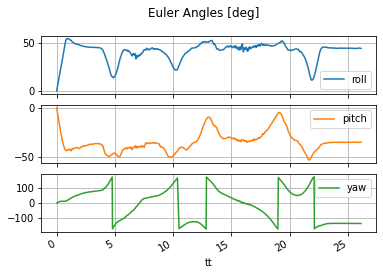

In [23]:
# The compass heading appears to go in the opposite dirction compared to the previous plot
euler.plot(x="tt", subplots=True, grid=True, title="Euler Angles [deg]");

# Ground Truth

During the process, I grabbed camera images that we can put into a movie and "see" what is going on. Hopefully you can visually match what is happending to what is plotted above.

In [24]:
# # simple function to save a video
# import platform
# def videoWrite(frames, fname='out.mp4'):
#     frame_height, frame_width, _ = frames[0].shape
    
#     # pick a good encoder for the current OS
#     sys = platform.system()
#     if sys in ['Darwin']:
#         fourcc = 'avc1'
#     else:
#         fourcc = 'mjpg'
        
#     out = cv2.VideoWriter(
#         fname,
#         cv2.VideoWriter_fourcc(*fourcc), 
#         30, 
#         (frame_width,frame_height))
#     for frame in frames:
#         out.write(frame)
#     out.release()

In [25]:
# frames = []
# for f, ts in cal['camera']:
#     frames.append(f)

# videoWrite(frames, 'sensor_data.mp4')

In [26]:
from IPython.display import Video
Video("sensor_data.mp4")

I think the yaw appears to track me spinning the IMU around in circles. However, I think the roll\pitch don't look right. I am not sure what is going on there.

# Images

This bag has some imagery.

In [27]:
import base64

frames = []
for f, ts in data['camera']:
    ss = base64.b64decode(f)
    nparr = np.frombuffer(ss, np.uint8)
    im = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
    im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
    frames.append(im)
    
print(f"Fount {len(frames)} images")

Fount 585 images


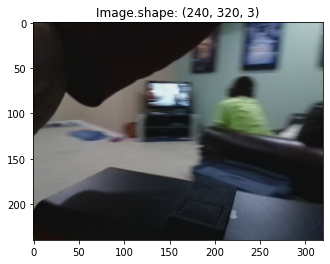

In [28]:
index = 320
img = frames[index]
plt.imshow(img)
plt.title(f"Image.shape: {img.shape}");

In [1]:
1/0.04

25.0